<a href="https://colab.research.google.com/github/bcecil2/Deep-Learning-From-Scratch/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import glob
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
tr = transforms.Compose([
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                                 transforms.ColorJitter(),
              ])

class FacadeDataset(Dataset):

  def __init__(self,path,transform):

    self.path= path
    self.X = []
    self.Y = []
    self.t = transform
    self.getPhotos()
    

  def getPhotos(self):
    for f in glob.glob(self.path+"/*.jpg"):
      image = read_image(f)
      image = image.to(torch.float32)
      X = image[:,:,256:]
      X = (X - X.min())/(X.max() - X.min())
      X = self.t(X)
      
      Y = image[:,:,:256]
      Y = (Y - Y.min())/(Y.max() - Y.min())
      Y = self.t(Y)
      self.X.append(X)
      self.Y.append(Y)

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

In [ ]:
trainDataset = FacadeDataset('./drive/MyDrive/facades/train',tr)
testDataset = FacadeDataset('./drive/MyDrive/facades/test',tr)
trainLoader = DataLoader(trainDataset,batch_size=2,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


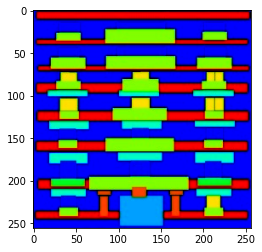

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


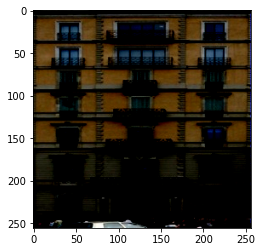

In [ ]:
for X,Y in trainLoader:
  print(X.shape)
  print(Y.shape)
  X = torch.transpose(X[0],0,2)
  X = torch.transpose(X,0,1)
  Y = torch.transpose(Y[0],0,2)
  Y = torch.transpose(Y,0,1)
  plt.imshow(X)
  plt.show()
  plt.imshow(Y)
  plt.show()
  break

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator,self).__init__()
    self.encoderLayers = [128,256,512,512,512,512,512]
    self.decoderLayers = [512,512,512,512,256,128,64]
    self.encoderList = nn.ModuleList([self.makeConvBlock(3,64,False,False,True)])
    prev = 64
    for i in self.encoderLayers:
      self.encoderList.append(self.makeConvBlock(prev,i,True,False,True))
      prev = i

    
    prev = self.decoderLayers[0]
    self.decoderList = nn.ModuleList([self.makeConvBlock(self.encoderLayers[-1],prev,True,True,False)])
    for i in self.decoderLayers[1:]:
      self.decoderList.append(self.makeConvBlock(prev*2,i,True,True,False))
      prev = i
    self.decoderList.append(nn.ConvTranspose2d(prev,256,1,2,output_padding=1))
    self.decoderList.append(nn.Conv2d(256,3,1))
    self.decoderList.append(nn.Tanh())
  
  def forward(self,x):
    skips = []
    n = len(self.encoderList)
    out = None
    for i,layer in enumerate(self.encoderList):
      x = layer(x)
      out = x
      # we dont save the last activation, not sure why
      # just inferred from architecture in paper
      if i != n-1:
        skips.append(x)
    
    skips = list(reversed(skips))
    for i,layer in enumerate(self.decoderList):
      if i != 0 and  i < len(skips):
        out = torch.cat([out,skips[i-1]],dim=1)
      out = layer(out)
    return out

  def makeConvBlock(self,inChannels,filters,batchNorm,dropout,down):
    conv = nn.Conv2d(inChannels,filters,4,2,1,bias=False) if down else nn.ConvTranspose2d(inChannels,filters,4,2,1,bias=False)
    bn = nn.BatchNorm2d(filters) if batchNorm else nn.Identity()
    d = nn.Dropout() if dropout else nn.Identity()
    relu = nn.LeakyReLU(0.2) if down else nn.ReLU()
    return nn.Sequential(conv,bn,d,relu)
  

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.sizes = [128,256,512]
    layers = [self.makeConvBlock(6,64,False,False,False)]
    prev = 64
    for s in self.sizes:
      layers.append(self.makeConvBlock(prev,s,True,False,True))
      prev = s
    layers += [nn.Conv2d(prev,1,4,2),nn.Sigmoid()]
    self.disc = nn.Sequential(*layers)
  
  def forward(self,x,y):
    return self.disc(torch.cat([x,y],dim=1))
  
  def makeConvBlock(self,inChannels,filters,batchNorm,dropout,down):
    conv = nn.Conv2d(inChannels,filters,4,2,1,bias=False) if down else nn.ConvTranspose2d(inChannels,filters,4,2,1,bias=False)
    bn = nn.BatchNorm2d(filters) if batchNorm else nn.Identity()
    d = nn.Dropout() if dropout else nn.Identity()
    relu = nn.LeakyReLU(0.2) if down else nn.ReLU()
    return nn.Sequential(conv,bn,d,relu)  

In [ ]:
G = Generator()
G = G.to('cuda')

D = Discriminator()
D = D.to('cuda')

In [ ]:
LR = 0.0001
EPOCHS = 400
L = 100
genOptim = optim.Adam(G.parameters(),lr=LR,betas=(0.5,0.999))
discOptim = optim.Adam(D.parameters(),lr=LR,betas=(0.5,0.999))
crit = nn.BCELoss()
L1 = nn.L1Loss()
it = 0
for e in range(EPOCHS):
  for i,(X,Y) in enumerate(trainLoader):
    X = X.to('cuda')
    Y = Y.to('cuda')

    yFake = G(X)
    DReal = D(X,Y)
    DRealLoss = crit(DReal,torch.ones_like(DReal))
    DFake = D(X,yFake.detach())
    DFakeLoss = crit(DFake,torch.zeros_like(DFake))
    DLoss = (DRealLoss + DFakeLoss)/2

    D.zero_grad()
    DLoss.backward()
    discOptim.step()

    DFake = D(X,yFake)
    GFakeLoss = crit(DFake,torch.ones_like(DFake))
    l1 = L1(yFake,Y)*L
    GLoss = GFakeLoss + l1

    genOptim.zero_grad()
    GLoss.backward()
    genOptim.step()

    if i % 50 == 0:
      print("Epoch {0}/{1}: DL: {2}, GL:{3}".format(e,EPOCHS,DLoss.item(),GLoss.item()))

    if (it % 200  == 0) or ((e == EPOCHS-1) and i == len(trainLoader)-1):
      vutils.save_image(yFake,'./drive/MyDrive/FacadesResults/fake'+str(it)+'.png',normalize=True)
    it += 1

Epoch 0/400: DL: 1.6081432104110718, GL:86.74337768554688
Epoch 0/400: DL: 0.0015482697635889053, GL:73.63621520996094
Epoch 0/400: DL: 0.0022983315866440535, GL:75.05895233154297
Epoch 0/400: DL: 0.0011058617383241653, GL:61.355831146240234
Epoch 1/400: DL: 0.0005221180035732687, GL:61.78644561767578
Epoch 1/400: DL: 0.0007466318784281611, GL:55.72329330444336
Epoch 1/400: DL: 0.0011985389282926917, GL:52.80453872680664
Epoch 1/400: DL: 0.0003757149388547987, GL:54.803855895996094
Epoch 2/400: DL: 0.0003633755259215832, GL:50.569366455078125
Epoch 2/400: DL: 0.0003987175296060741, GL:49.92216110229492
Epoch 2/400: DL: 0.00029461990925483406, GL:47.12614440917969
Epoch 2/400: DL: 0.0006075454293750226, GL:41.8723258972168
Epoch 3/400: DL: 0.00016953813610598445, GL:51.55606460571289
Epoch 3/400: DL: 0.00012273677566554397, GL:48.60040283203125
Epoch 3/400: DL: 0.00013760922593064606, GL:46.72197341918945
Epoch 3/400: DL: 0.00011281551996944472, GL:50.235870361328125
Epoch 4/400: DL: 7.

In [ ]:
torch.save(G.state_dict(),'./drive/MyDrive/Pix2PixGen.pt')
torch.save(D.state_dict(),'./drive/MyDrive/Pix2PixDisc.pt')

NameError: ignored